# 負荷の日間変動グラフの作成

#### データ読み込み

In [2]:
from scipy.io import loadmat # type: ignore
import pandas as pd
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

#データ読み込み
df_location = pd.read_csv('df_location_processed.csv')
df_csPosition_dss_shikata = pd.read_csv('csPosition_dss_shikata.csv')

#アルファベットの小文字化を行っておく
df_csPosition_dss_shikata['Node'] = df_csPosition_dss_shikata['Node'].str.lower()

case_list = ['50']
#case_list = ['on']
#case_list = ['on','off']

#csの種類
cstype = ['N','F']

load_list = ['cs','pv','homeload']

day_str= '0401'
#負荷データを収める辞書
df_loaddata_dict = { key: 0 for key in case_list} 

for case in case_list:
    df_loaddata_dict[case] = {key:0 for key in load_list}
    
    for load in load_list:
        df_loaddata_dict[case][load] = pd.read_csv(f'df_{load}_{case}.csv')

#df_locationのインデックスをノード名にしておく(参照しやすくなるため)

df_location =  df_location.set_index('Node', drop=True)

df_csPosition_dss_shikata = df_csPosition_dss_shikata.set_index('Node', drop=True)
#同じ行名を持つ行を最初の行に絞る
df_csPosition_dss_shikata = df_csPosition_dss_shikata[~df_csPosition_dss_shikata.index.duplicated(keep='first')]



# print(df_csPosition_dss_shikata) 


#### データ成型

In [3]:


# フィーダーごとにデータを集計する
feeder_list = [21, 22, 23, 24, 25, 26, 28]
# feeder_list = [23]
#負荷の合計値を収める辞書
df_load_sum_dict = { key: 0 for key in case_list} 

#matdataにはあるがdf_location内に存在しないノード
notexist_node = []

for case in case_list:
    df_load_sum_dict[case] = {key:0 for key in load_list+['total']}

    for load in load_list+['total']:
        if load == 'cs':
            df_load_sum_dict[case][load] = {key:0 for key in cstype}
            for type in cstype:
                df_load_sum_dict[case][load][type] = {key:0 for key in feeder_list}

            
        else:
            df_load_sum_dict[case][load] = {key:0 for key in feeder_list}


#フィーダーごとに各負荷を積算する

for case in case_list:

    for load in load_list:

        #for文が実行されているか確かめるためのカウンタ
        nodecount = 0

        for node in df_loaddata_dict[case][load].columns:
            if load == 'cs':
                try:
                    feeder = df_location.loc[ node , 'Feeder']
                    type = df_csPosition_dss_shikata.loc[ node , 'type']
                
                    
                    df_load_sum_dict[case][load][type][feeder] += df_loaddata_dict[case][load][node]
                    
                    nodecount += 1

                except:
                    print (f'{node} do not exist in df_location_processed or csPosition_dss_shikata')
                   
                    notexist_node.append(node)
            else:
                try:
                    feeder = df_location.loc[ node , 'Feeder']

                    df_load_sum_dict[case][load][feeder] += df_loaddata_dict[case][load][node]
                    
                    nodecount += 1

                except:
                    print (f'{node} do not exist in in df_location_processed or csPosition_dss_shikata')
                    node.append(notexist_node)

        print (case, load)
        print (nodecount)
print ('notexist_node')
print (len(notexist_node))
#フィーダーごとに全負荷を計算する
for case in case_list:

    for feeder in feeder_list:

        for load in load_list:
            if load == 'cs':
                for type in cstype:
                    df_load_sum_dict[case]['total'][feeder] += df_load_sum_dict[case][load][type][feeder]
            else:
                df_load_sum_dict[case]['total'][feeder] += df_load_sum_dict[case][load][feeder]

50 cs
52
50 pv
61
50 homeload
103
notexist_node
0


#### プロット

C:\Users\Shin\AppData\Local\Temp\ipykernel_65204\2259354066.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{h//360:02d}:{(h%360)//60:02d}" for h in hours], rotation=30, ha='center',size=28)
C:\Users\Shin\AppData\Local\Temp\ipykernel_65204\2259354066.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{h//360:02d}:{(h%360)//60:02d}" for h in hours], rotation=30, ha='center',size=28)
C:\Users\Shin\AppData\Local\Temp\ipykernel_65204\2259354066.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{h//360:02d}:{(h%360)//60:02d}" for h in hours], rotation=30, ha='center',size=28)
C:\Users\Shin\AppData\Local\Temp\ipykernel_65204\2259354066.py:93: UserWarning: set_ticklabels

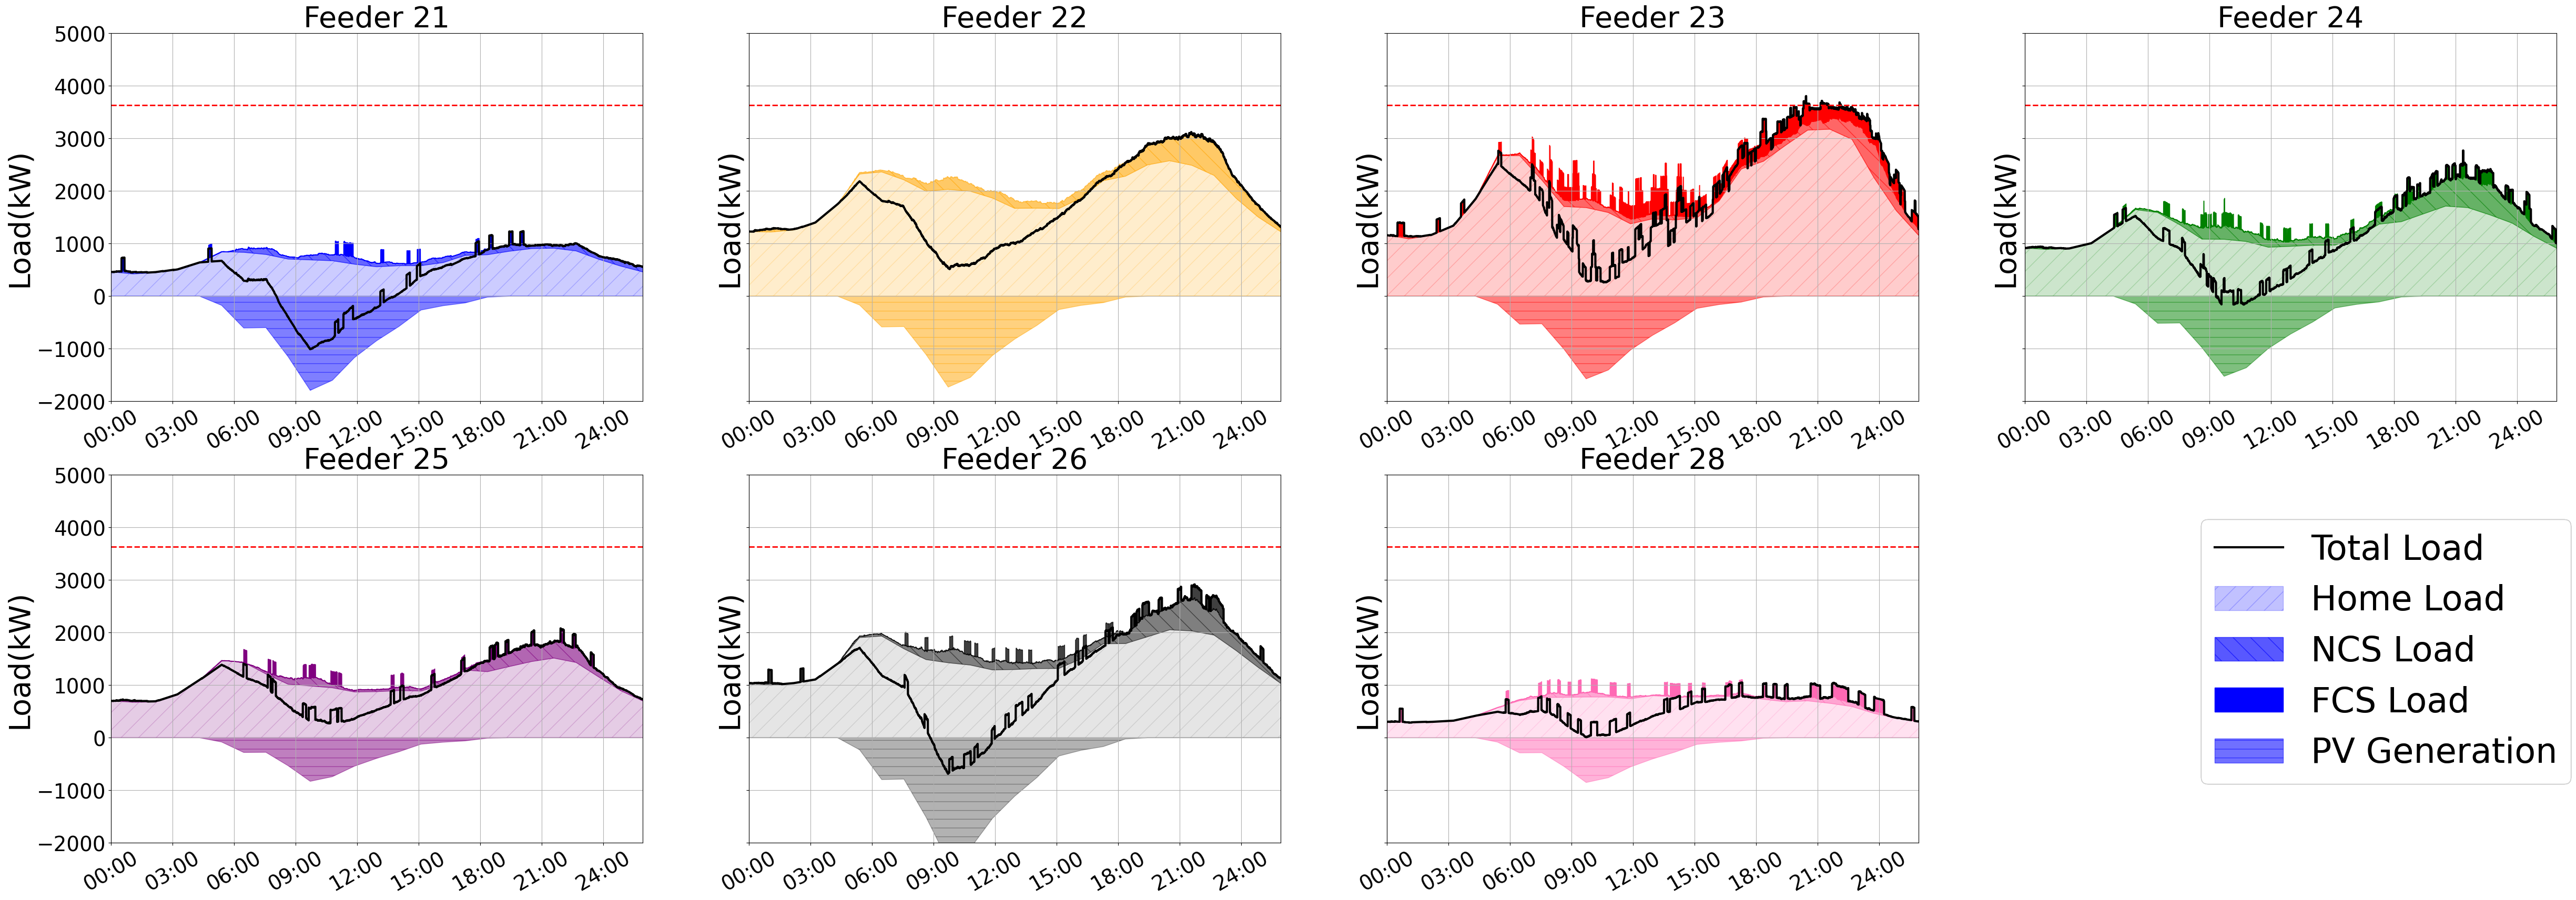

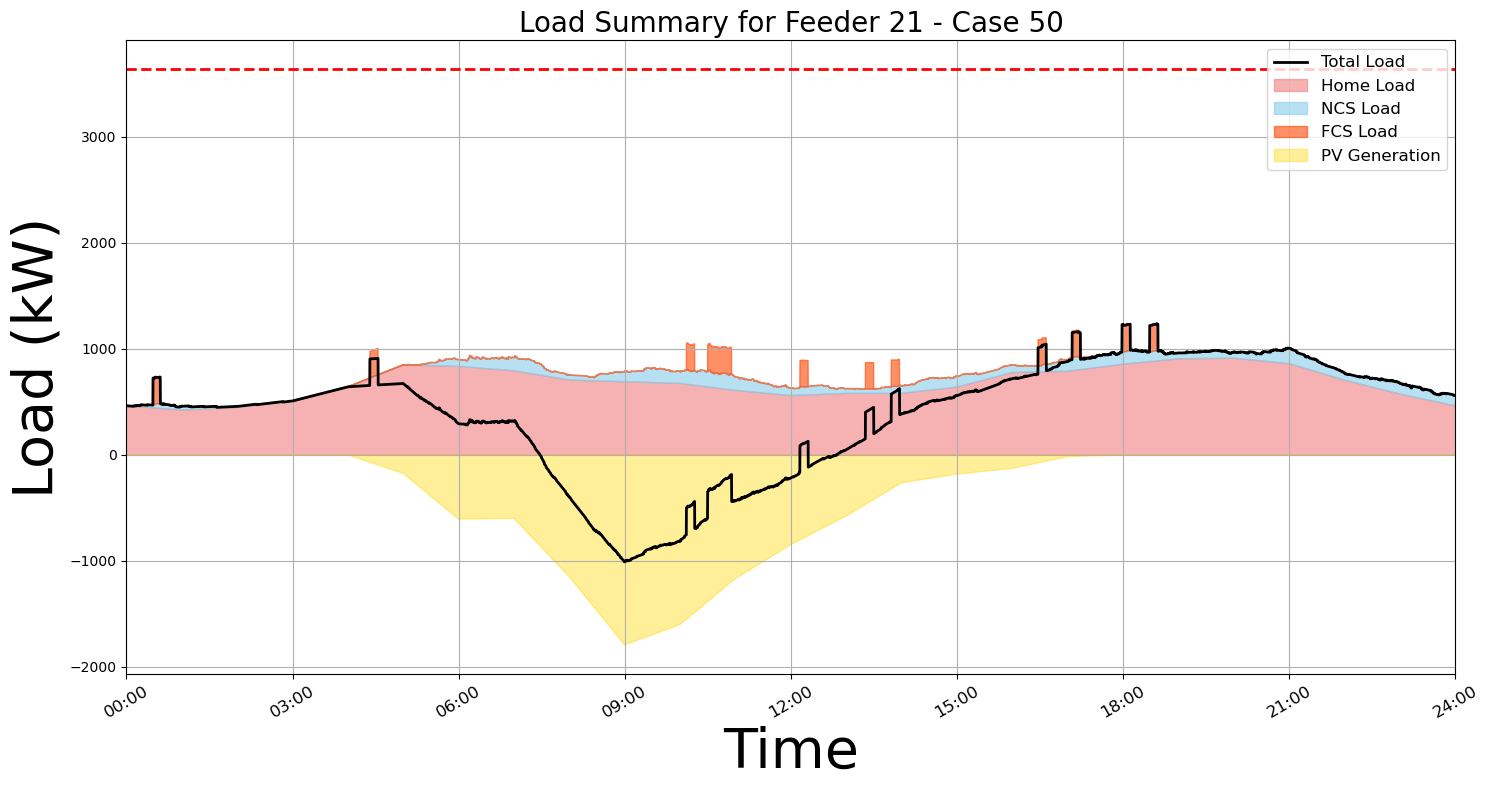

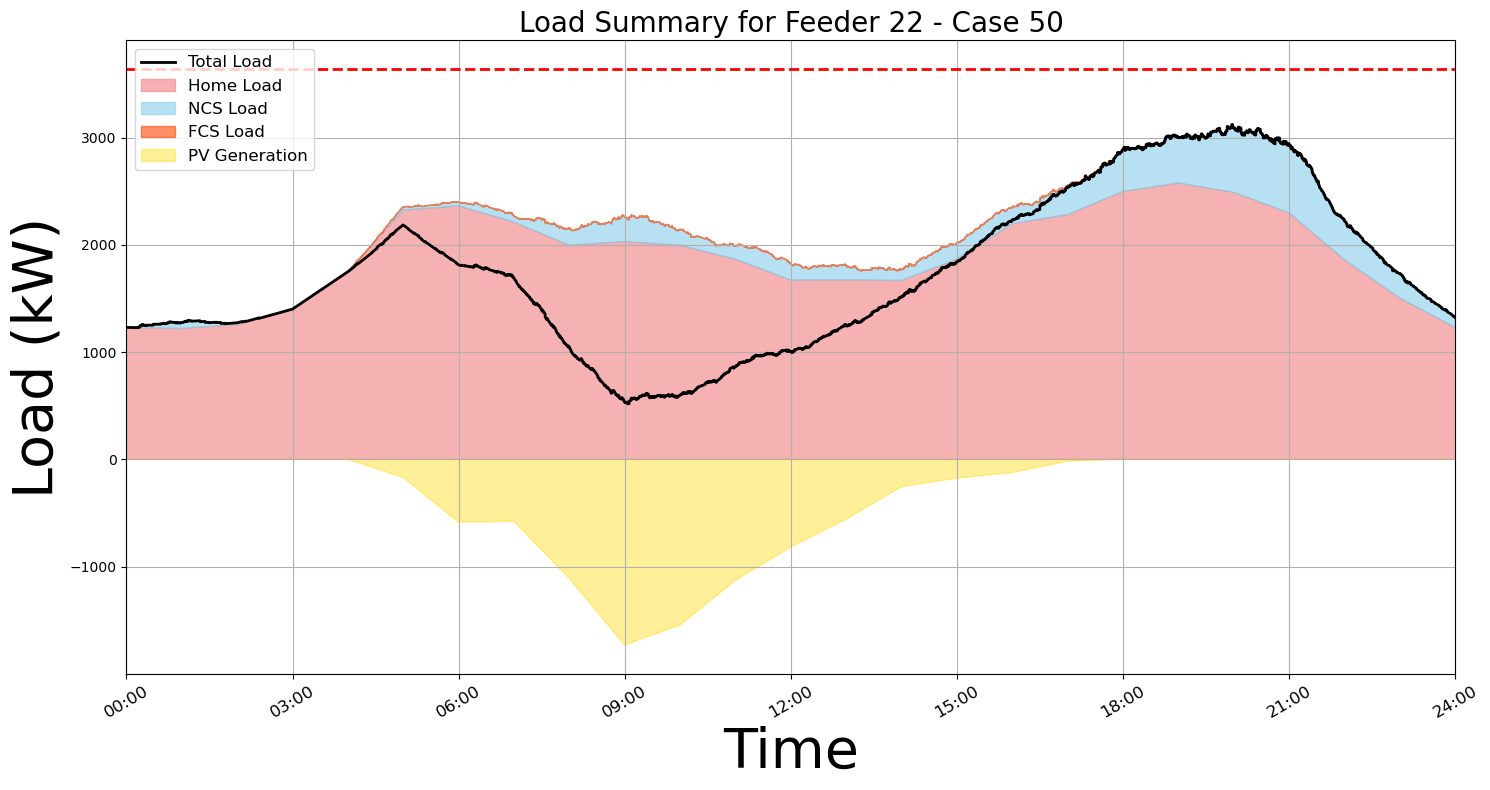

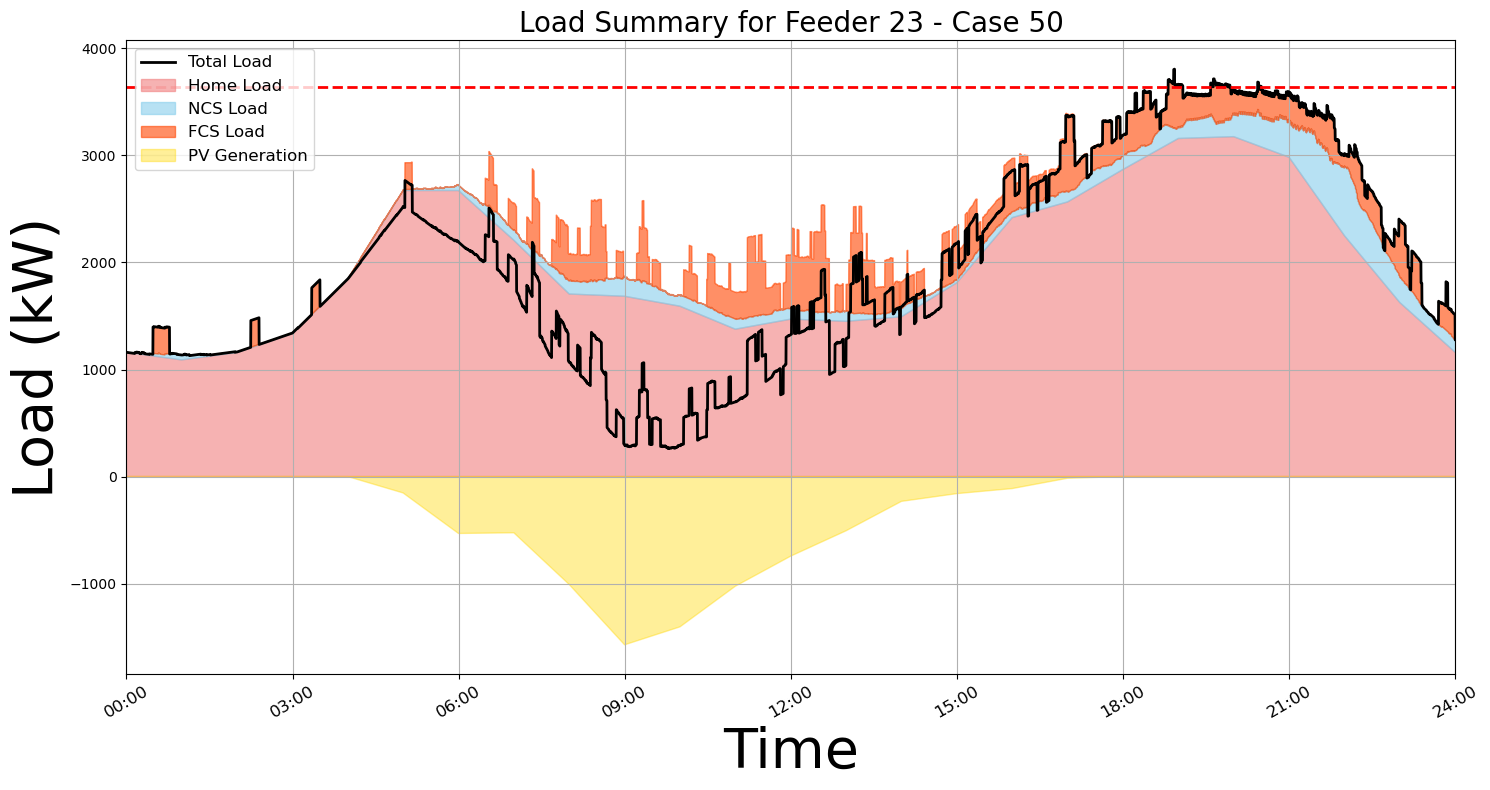

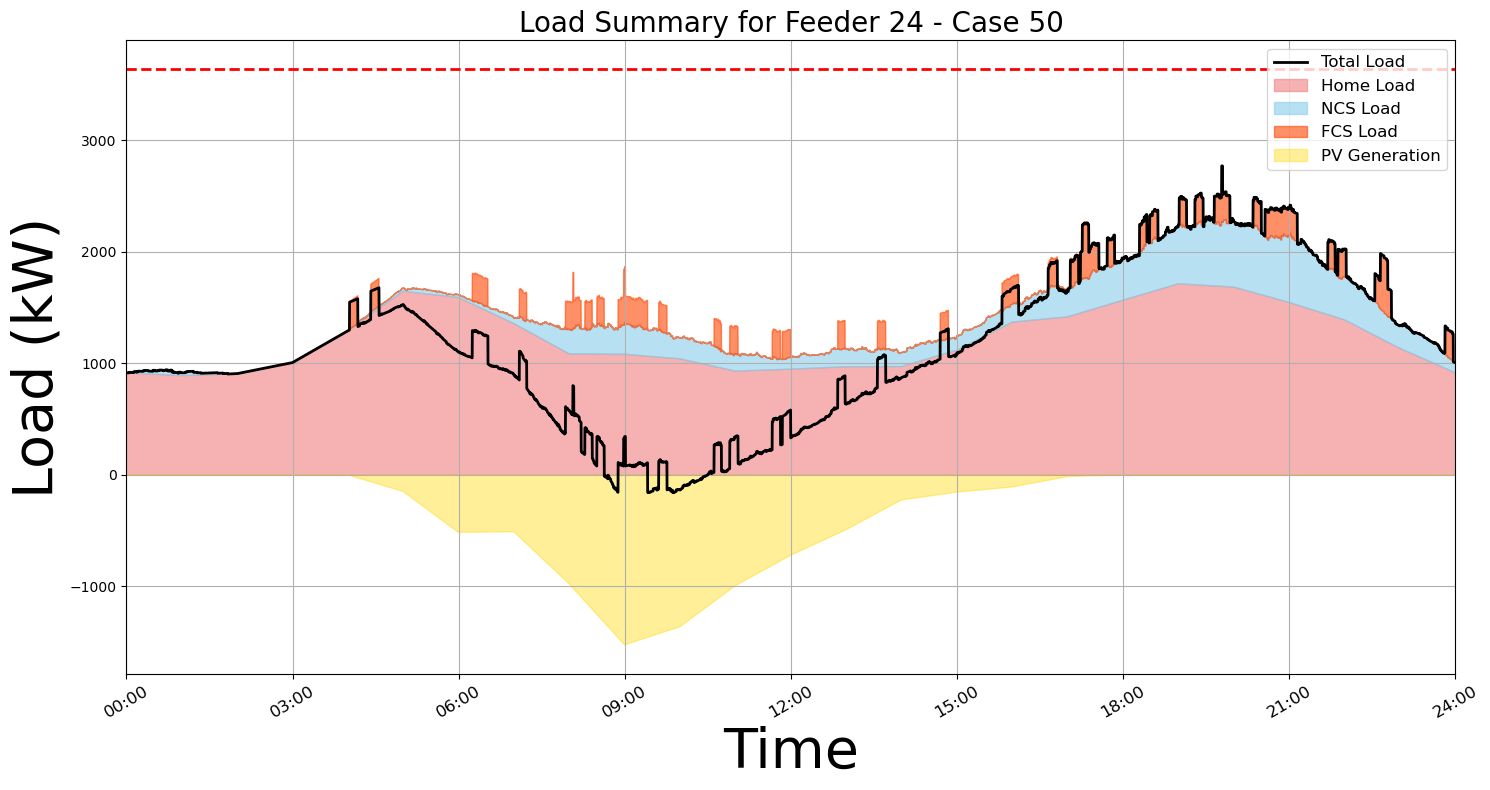

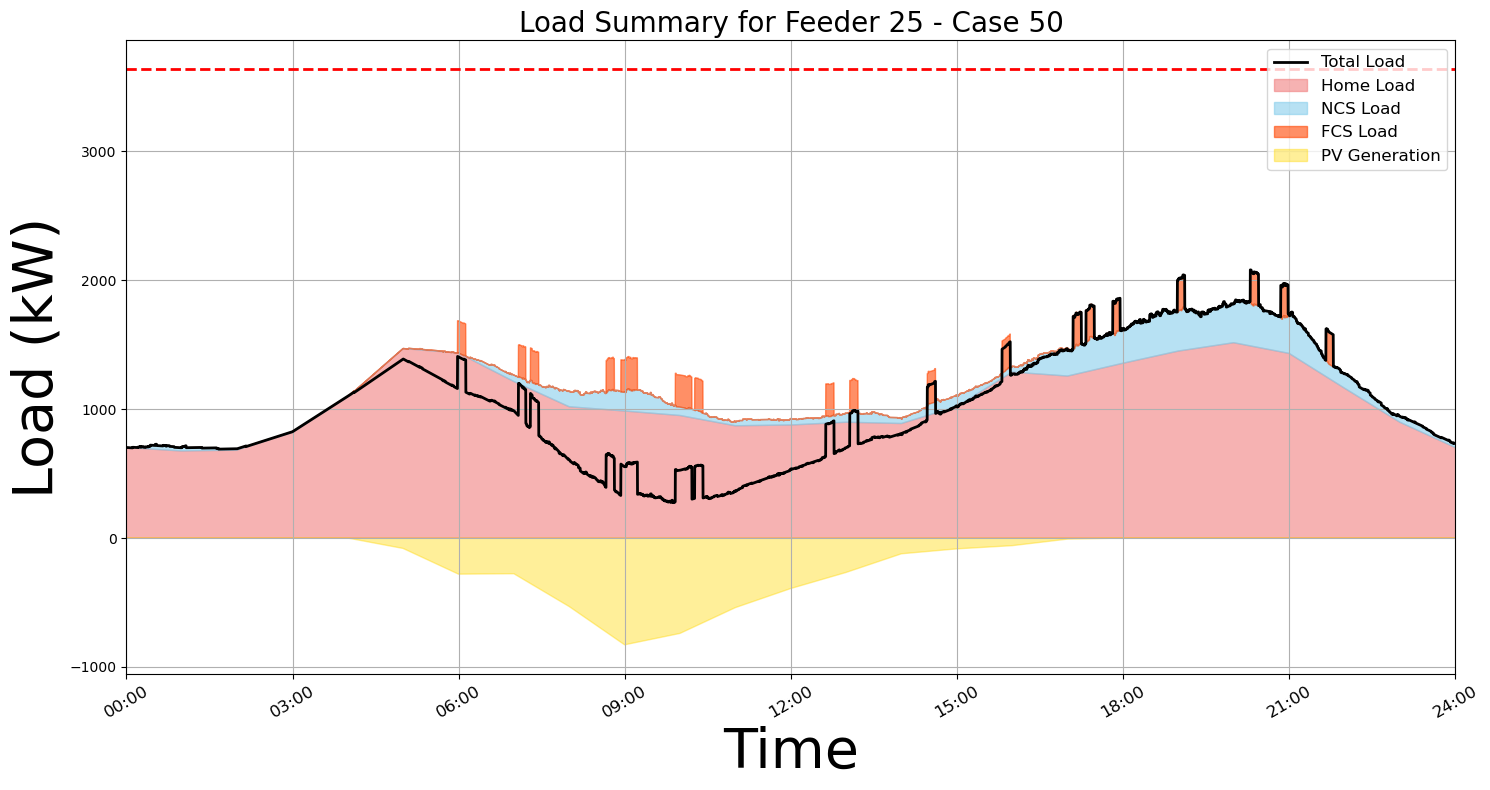

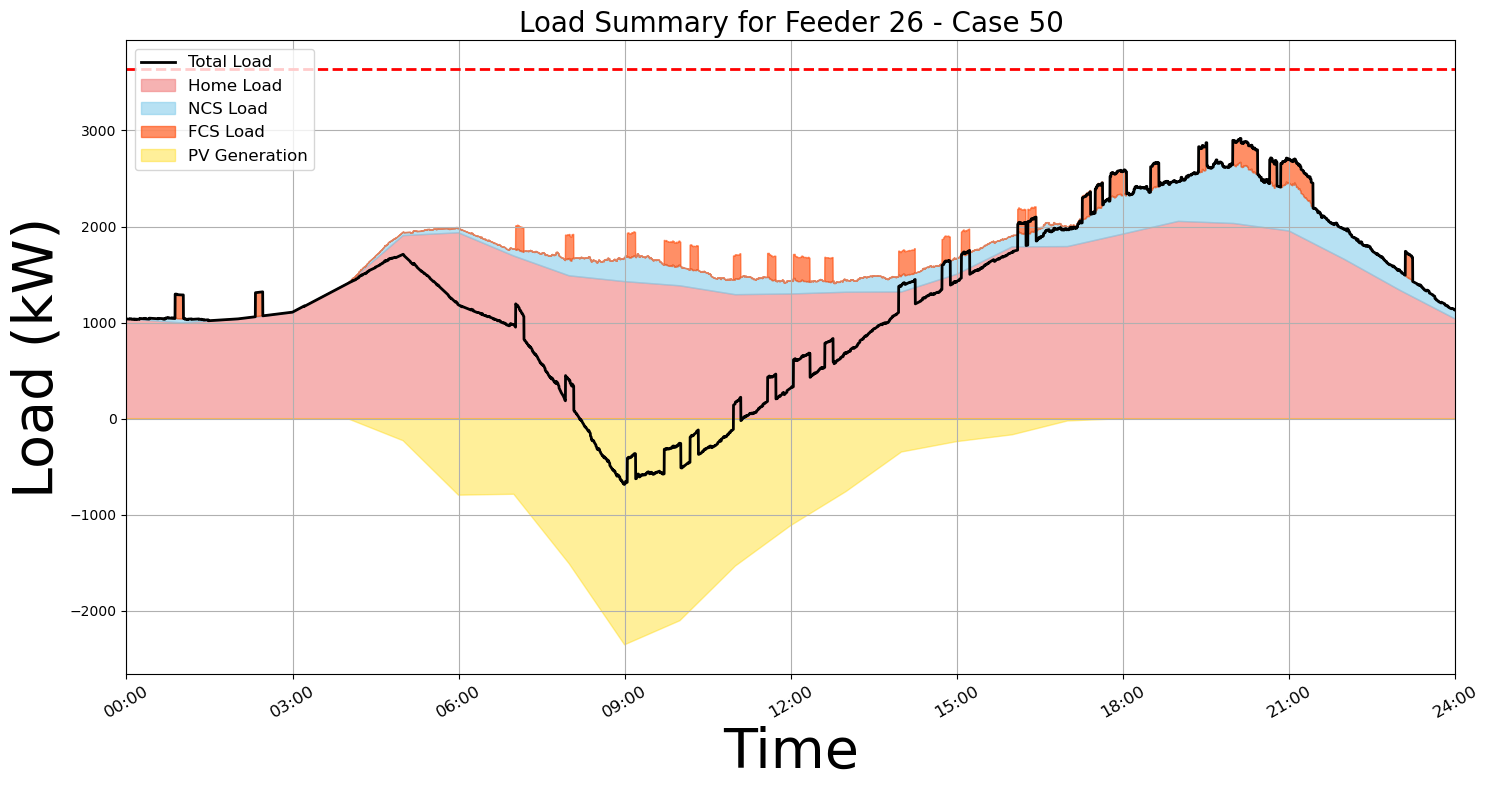

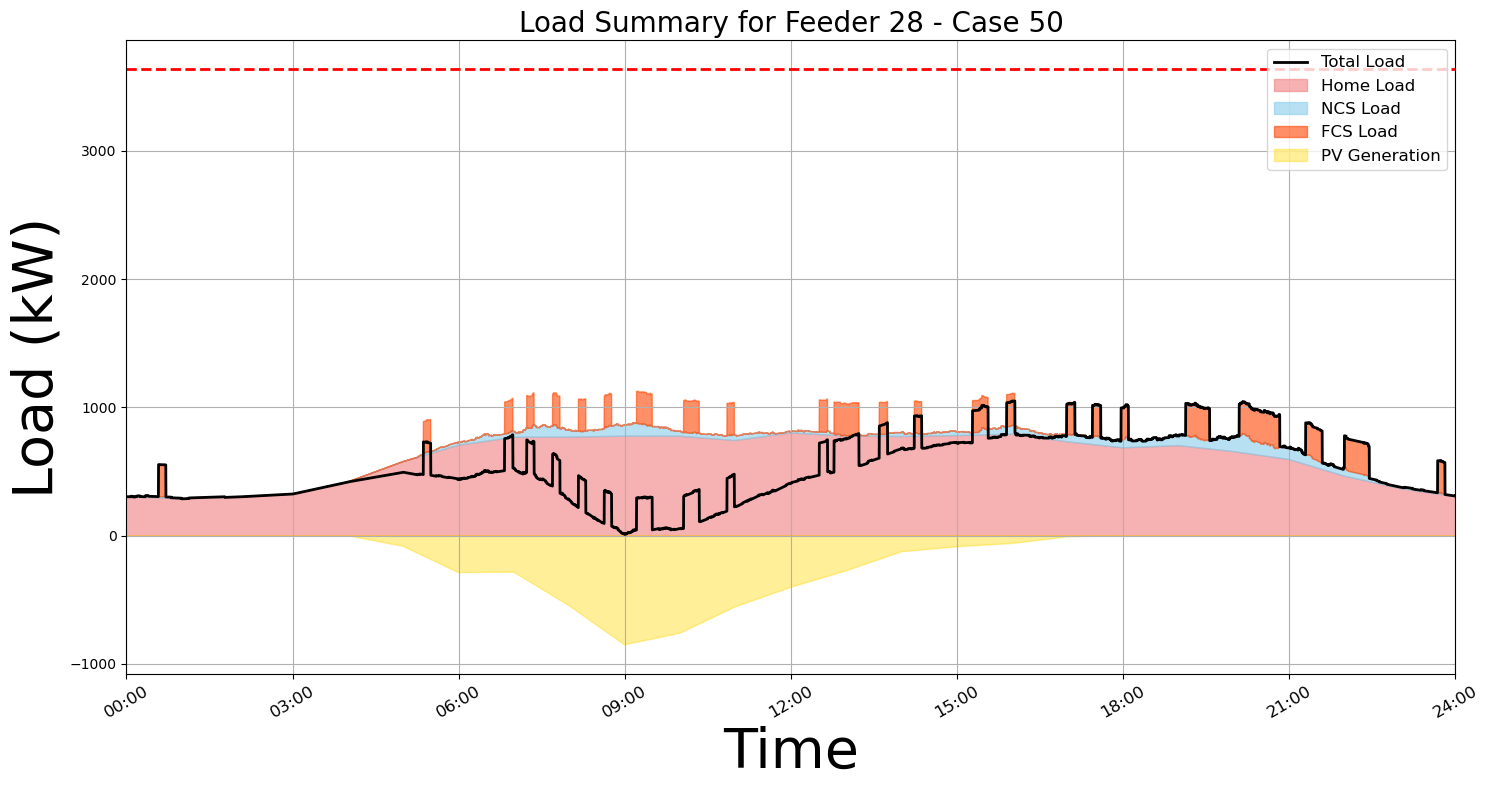

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

feeder_colors = {
    21: 'blue',
    22: 'orange',
    23: 'red',
    24: 'green',
    25: 'purple',
    26: 'black',
    28: 'hotpink',
    # 他のFeederについても追加
}

hours = np.arange(0, 8641, 1080)  # 0から8640までの秒数を3時間ごとに  # 時間軸の設定
ax_dict = {key : 0 for key in case_list}

for case in case_list:
    
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(60, 20), sharey="all") #, sharex="all
    for idx in range(7):
        n = feeder_list[idx]
        summarizedload = df_load_sum_dict[case]['total'][n]
        homeload = df_load_sum_dict[case]['homeload'][n]
        #CSの種類ごと
        csload_dict = {type : 0 for type in cstype}
        csload_dict[cstype[0]] = df_load_sum_dict[case]['cs'][cstype[0]][n]
        csload_dict[cstype[1]] = df_load_sum_dict[case]['cs'][cstype[1]][n]
        pv = df_load_sum_dict[case]['pv'][n]  

        ax= axes[idx // 4, idx % 4] 
        
        color=feeder_colors[n]

        # 合計負荷をプロット
        ax.plot(csload_dict[cstype[0]].index, summarizedload , 'black', linewidth=3, label='Total Load')
        
        #網掛けで各不可を見分けやすく(黒の時だけ彩度を調整)
        if color == 'black':
            base_line = (0)  # 基準線（0から始まる）

            ax.fill_between(csload_dict[cstype[0]].index, base_line, homeload, color=mcolors.to_rgba(color, alpha=0.1), hatch='/')

            # NCS Loadの領域を描画（Home Loadの上に積み重ねる）
            ncsload_top = homeload + csload_dict[cstype[0]]  # NCS Loadの上限
            
            ax.fill_between(csload_dict[cstype[0]].index, homeload, ncsload_top, color=mcolors.to_rgba(color, alpha=0.5), hatch='\\' )

            # FCS Loadの領域を描画（NCS Loadの上に積み重ねる）
            fcsload_top = ncsload_top + csload_dict[cstype[1]]  # FCS Loadの上限
            
            ax.fill_between(csload_dict[cstype[1]].index,ncsload_top, fcsload_top, color=mcolors.to_rgba(color, alpha=0.75) )

            # PV Generationの領域を描画
            pvgen_top =  pv  # PV Generationの上限
            ax.fill_between(csload_dict[cstype[0]].index, base_line, pvgen_top, color=(mcolors.to_rgba(color)[0], mcolors.to_rgba(color)[1], mcolors.to_rgba(color)[2], 0.3), hatch='-')
        else:
            base_line = (0)  # 基準線（0から始まる）

            ax.fill_between(csload_dict[cstype[0]].index, base_line, homeload, color=mcolors.to_rgba(color, alpha=0.2), hatch='/')

            # NCS Loadの領域を描画（Home Loadの上に積み重ねる）
            ncsload_top = homeload + csload_dict[cstype[0]]  # NCS Loadの上限
            
            ax.fill_between(csload_dict[cstype[0]].index, homeload, ncsload_top, color=mcolors.to_rgba(color, alpha=0.6), hatch='\\' )

            #if not csload_dict[cstype[1]].empty:
            if isinstance(csload_dict[cstype[1]], pd.Series) and not csload_dict[cstype[1]].empty:
                # FCS Loadの領域を描画（NCS Loadの上に積み重ねる）
                fcsload_top = ncsload_top + csload_dict[cstype[1]]  # FCS Loadの上限
                ax.fill_between(csload_dict[cstype[1]].index, ncsload_top, fcsload_top, color=mcolors.to_rgba(color, alpha=1.0) )

            # PV Generationの領域を描画
            pvgen_top =  pv  # PV Generationの上限
            ax.fill_between(csload_dict[cstype[0]].index, base_line, pvgen_top, color=(mcolors.to_rgba(color)[0], mcolors.to_rgba(color)[1], mcolors.to_rgba(color)[2], 0.5), hatch='-')

        ax.set_title(f"Feeder {n}",size=40)
        
        ax.set_xlim(0, 8640)

        ax.set_ylabel('Load(kW)' ,size=40)

        ax.set_ylim(-2000, 5000)
     
    # 凡例を図全体に対して追加(位置も調整)
        fig.legend(['Total Load','Home Load', 'NCS Load', 'FCS Load', 'PV Generation'], loc='lower right', fontsize=47, bbox_to_anchor=(0.91, 0.15))
        #fig.legend(['Total Load','Home Load', 'PV Generation'], loc='lower right', fontsize=47, bbox_to_anchor=(0.91, 0.15))       

        if idx == 6:  # 7つ目のフィーダーのデータをプロットした後
            unused_ax = axes[1, 3]  # 2行4列の最後のサブプロット
            unused_ax.set_visible(False)  # 余ったサブプロットを非表示にする
        ax.set_xticklabels([f"{h//360:02d}:{(h%360)//60:02d}" for h in hours], rotation=30, ha='center',size=28)

        ax.yaxis.set_tick_params(labelsize=28)
        ax.hlines(3638,0,8640 ,color='red',linestyle='dashed',linewidth=2)
        ax.hlines(-3638,0,8640 ,color='red',linestyle='dashed',linewidth=2)
        ax.grid(True)

    #保存
    plt.savefig( f'load_stackplot_{case}.png')
    plt.show()


# feederごとに各負荷を積算する
for case in case_list:

    for feeder in feeder_list:
        total_load = df_load_sum_dict[case]['total'][feeder]
        home_load = df_load_sum_dict[case]['homeload'][feeder]
        cs_n_load = df_load_sum_dict[case]['cs']['N'][feeder]
        cs_f_load = df_load_sum_dict[case]['cs']['F'][feeder]
        pv_load = df_load_sum_dict[case]['pv'][feeder]

        # グラフの作成
        fig, ax = plt.subplots(figsize=(15, 8))
        ax.plot(total_load.index, total_load, label='Total Load', color='black', linewidth=2)
        ax.fill_between(total_load.index, 0, home_load, label='Home Load', color='lightcoral', alpha=0.6)
        ax.fill_between(total_load.index, home_load, home_load + cs_n_load, label='NCS Load', color='skyblue', alpha=0.6)
        ax.fill_between(total_load.index, home_load + cs_n_load, home_load + cs_n_load + cs_f_load, label='FCS Load', color='orangered', alpha=0.6)
        ax.fill_between(total_load.index, 0, pv_load, label='PV Generation', color='gold', alpha=0.4)

        ax.set_title(f'Load Summary for Feeder {feeder} - Case {case}', size=20)
        ax.set_xlim(0, 8640)
        ax.set_xticks(hours)
        ax.set_xticklabels([f"{h//360:02d}:{(h%360)//60:02d}" for h in hours], rotation=30, ha='center', size=12)
        ax.set_xlabel('Time', size=40)
        ax.set_ylabel('Load (kW)', size=40)
        ax.hlines(3638,0,8640 ,color='red',linestyle='dashed',linewidth=2)
        ax.legend(fontsize=12)
        ax.grid()
        plt.tight_layout()
        plt.savefig(f'feeder_{feeder}_load_summary_{case}.png')
        plt.show()
